In [225]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import torch
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
os.makedirs('img_res', exist_ok=True) #creates a folder to store the loss graphs
os.makedirs('test_res', exist_ok=True) #creates a folder to store the files of the testing of the model
import functions as f #import functions used to plot

In [34]:
#I found a warning regarding the key names for energy and forces, the label changes from 'energy' to 'REF_energy'
input_file = "251017_training_data.xyz"
output_file = "251017_training_data_fixed.xyz"

with open(input_file, "r") as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # Fix energy key in header lines
    if "energy=" in line:
        line = line.replace("energy=", "REF_energy=")
    # Fix forces key in Properties line
    if "Properties=" in line and "forces:R:3" in line:
        line = line.replace("forces:R:3", "REF_forces:R:3")
    new_lines.append(line)

# Write the fixed file
with open(output_file, "w") as f:
    f.writelines(new_lines)

In [35]:
#importing the full data (this is in case I have like the whole data in one file)
db = read('251017_training_data_fixed.xyz', ':')

In [36]:
#splitting the data into the training and test sets
write('train_01.xyz', db[:520])
write('test_01.xyz', db[520:])

In [ ]:
#setting the model name based on model number and epochs
device = 'cpu'
''' model_num:
    1 -> this indicates the model using 250 training data
    2 -> this indicates the model using 520 training data which is 80% of the data set
    3,4 -> this indicates the model using different values of learning rate 0.005, 0.0001 '''
model_num = 'scaleshift_lr0.0001'
#model_num = 4
''' num_epochs:
    sets the number of epochs used for running the trainig'''
num_epoch = 30
''' batch_size:
    sets the batch size for training'''
batch_size = 40
''' model_name:
    generates the name of the model based on the number of epochs and the model number using the 'model_num' variable '''
model_name = f'model_0{model_num}_{num_epoch}epochs_{batch_size}batch'
model_name

'model_0scaleshift_lr0.0001_30epochs_26batch'

In [305]:
#this writes the yml file
config = {
    "model": "ScaleShiftMACE",
    #"model": "MACE",
    "num_channels": 32,
    "max_L": 0,
    "r_max": 4.0,
    "name": model_name,
    "train_file": f"train_01.xyz",
    "valid_fraction": 0.01,
    "test_file": f"test_01.xyz",
    "energy_key": "REF_energy",
    "forces_key": "REF_forces",
    "batch_size": batch_size,
    "max_num_epochs": num_epoch,
    "optimizer" : "adam",
    "lr":0.0001,
    "device": device,
    "seed": 123
}
with open("config_new_model.yml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

In [306]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') # use the name of the config file that was created

2025-10-29 23:27:43.998 INFO: ===========VERIFYING SETTINGS===========
2025-10-29 23:27:43.999 INFO: MACE version: 0.3.14
2025-10-29 23:27:43.999 INFO: Using CPU
2025-10-29 23:27:44.042 INFO: ===========LOADING INPUT DATA===========
2025-10-29 23:27:44.043 INFO: Using heads: ['Default']
2025-10-29 23:27:44.044 INFO: Using the key specifications to parse data:
2025-10-29 23:27:44.044 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-10-29 23:27:44.045 INFO: =============    Processing head Default     ===========
2025-10-29 23:27:44.118 INFO: Using isolated atom energies from training file
2025-10-29 23:27:44.129 INFO: Training set 1/1 [energy: 517, stress: 0, virials: 0, dipole components: 0, hea

In [307]:
#reading the information on the results file
results = f'results/{model_name}_run-123_train.txt' #reading the file where the training results is stored
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [308]:
results

'results/model_0scaleshift_lr0.0001_30epochs_26batch_run-123_train.txt'

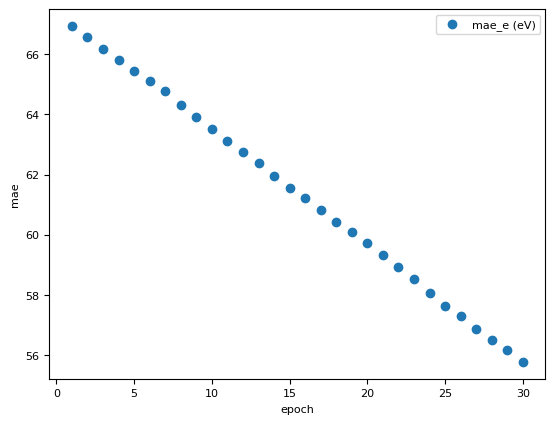

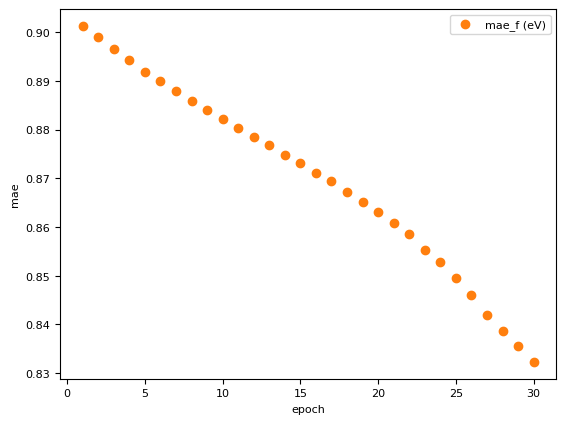

In [309]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy().dropna()
#train_df = train_df.groupby('epoch', as_index=False)['loss'].last()
train_df = train_df.groupby('epoch', as_index=False)['loss'].mean()
train_df['epoch'] += 1
val_df['epoch'] += 1

#plotting the dataframe
import functions as f
f.plot_mae(val_df, 'epoch', ['mae_e','mae_f'])

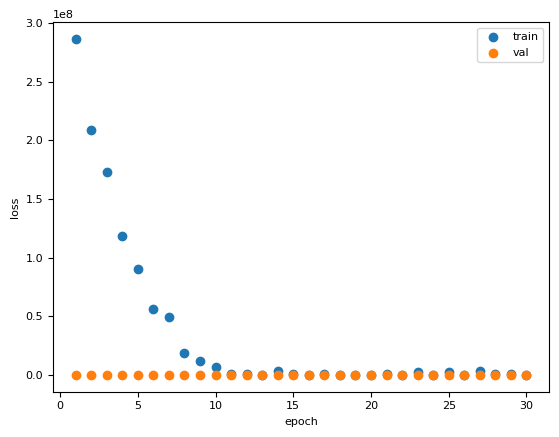

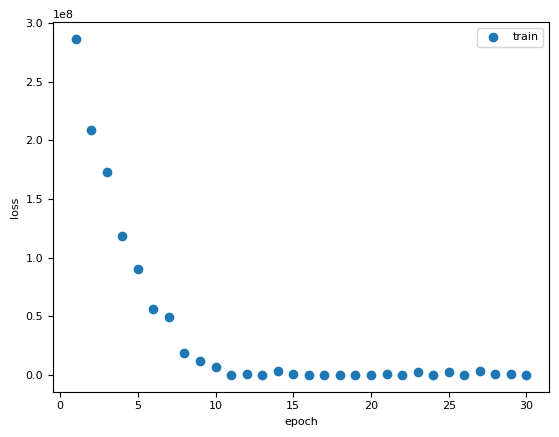

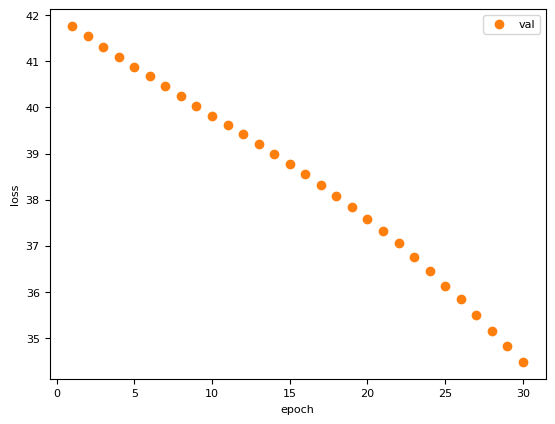

In [310]:
#plotting the validation and loss error
f.plot_loss([(train_df, 'train'),(val_df,'val')],'epoch','loss',model_name)

In [311]:
#the model can be evaluated using this
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(model, configs, output, device=device):
    sys.argv=['program', '--configs', configs, '--model', model, '--output', output, '--device', device]
    mace_eval_configs_main()

In [316]:
#evaluating the set on both the training and test datasets
'''eval_mace(model=f'{model_name}.model',
          configs='train_01.xyz',
          output=f'test_res/{model_name}_train.xyz')'''

eval_mace(model=f'{model_name}.model',
          configs='test_01.xyz',
          output=f'test_res/{model_name}_test.xyz')

2025-10-29 23:45:18.571 INFO: Using CPU


In [313]:
from ase.io import read

#importing data from the evaluation of the test set
#read the configurations with the mace predictions
res_list = read(f'test_res/{model_name}_test.xyz', index=':')
#extracting the reference and mace energies
res = [(a.info['REF_energy'], a.info['MACE_energy']) for a in res_list]
df_res = pd.DataFrame(res, columns=['REF_energy', 'MACE_energy'])
df_res

,REF_energy,MACE_energy
0,-108.197314,-160.240049
1,-108.155668,-160.304069
2,-107.938072,-160.005873
3,-111.978524,-160.919574
4,-111.939598,-160.819123
...,...,...
128,-106.479300,-160.133867
129,-102.204540,-159.889155
130,-101.649356,-160.189435
131,-98.841753,-160.010395


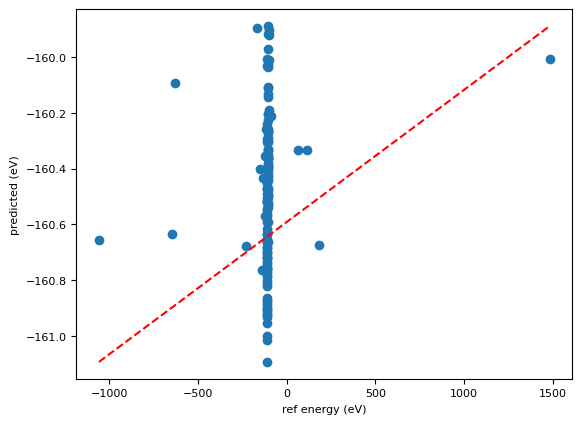

In [314]:
f.plot_energy_comparison(df_res, 'REF_energy', 'MACE_energy')

In [315]:
'''#this is commented for now because we have set the data on which the energy and forces will be calculated
#once the training is done, then a calculation can be performed using ase
from ase.io import read
from mace.calculators import MACECalculator

#loading the model
calculator = MACECalculator(model_paths=f'{model_name}.model', device='cuda')
#read the configurations from where we want to calculate
### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data
configs = read('test_01.xyz', ':')

#set a list to store the information
results = []
# read the results
for i, atoms in enumerate(configs):
    atoms.set_calculator(calculator)
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    #max_force = abs(forces).max()  # max absolute force
    #mean_force = abs(forces).mean()  # mean absolute force
    # Add to list
    results.append({
        "config_id": i,
        "energy (eV)": energy,
    #    "max_force (eV/Å)": max_force,
    #    "mean_force (eV/Å)": mean_force,
        "num_atoms": len(atoms)
    })
# Create dataframe
df = pd.DataFrame(results)
df.to_excel(f'{model_name}.xlsx', index=False) #this is to save the results in an exel file'''

'#this is commented for now because we have set the data on which the energy and forces will be calculated\n#once the training is done, then a calculation can be performed using ase\nfrom ase.io import read\nfrom mace.calculators import MACECalculator\n\n#loading the model\ncalculator = MACECalculator(model_paths=f\'{model_name}.model\', device=\'cuda\')\n#read the configurations from where we want to calculate\n### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data\nconfigs = read(\'test_01.xyz\', \':\')\n\n#set a list to store the information\nresults = []\n# read the results\nfor i, atoms in enumerate(configs):\n    atoms.set_calculator(calculator)\n    energy = atoms.get_potential_energy()\n    forces = atoms.get_forces()\n    #max_force = abs(forces).max()  # max absolute force\n    #mean_force = abs(forces).mean()  # mean absolute force\n    # Add to list\n    results.append({\n        "config_id": i,\n      

In [319]:
read_test = read('train_01.xyz', index=':')
db_test = [(a.info['REF_energy']) for a in read_test]
df = pd.DataFrame(db_test, columns=['REF_energy'])
df

,REF_energy
0,-3.283081
1,-0.810493
2,-0.275595
3,-44.585548
4,-48.184644
...,...
515,-165.588895
516,-109.164985
517,-110.593133
518,-108.329711


In [321]:
df.min()

REF_energy   -29322.535908
dtype: float64